In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

In [3]:
train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dict_x_train = train.ix[:,'0':]
pixel_train = dict_x_train.as_matrix()
dict_y_train = train.ix[:,'5']
label = dict_y_train.as_matrix()

dict_x_test = test.ix[:,'0':]
pixel_test = dict_x_test.as_matrix()
dict_y_test = test.ix[:,'7']
label_test = dict_y_test.as_matrix()

In [5]:
np.shape(pixel_test)

(9999, 784)

In [6]:
mean_train = np.mean(pixel_train,axis = 1)
std_train = np.std(pixel_train,axis = 1)

mean_test = np.mean(pixel_test,axis = 1)
std_test = np.std(pixel_test,axis = 1)

Pre-processing the data. np.tile create matrix with duplicated rows or columns

In [7]:
mean_temp_train = np.tile(mean_train,[784,1])
mean_temp_train = mean_temp_train.transpose()

std_temp_train = np.tile(std_train,[784,1])
std_temp_train = std_temp_train.transpose()


mean_temp_test = np.tile(mean_test,[784,1])
mean_temp_test = mean_temp_test.transpose()

std_temp_test = np.tile(std_test,[784,1])
std_temp_test = std_temp_test.transpose()

In [8]:
zero_mean_train = pixel_train - mean_temp_train
data = zero_mean_train/std_temp_train


zero_mean_test = pixel_test - mean_temp_test
test_data = zero_mean_test/std_temp_test

In [9]:
np.shape(train)

(59999, 785)

In [10]:
train_data = data

In [11]:
data = train_data[0:42000,:]
validate = train_data[42001:54000,:]
testdata = train_data[54001:59998,:]

label_data = train.ix[0:42000,:]
label_validate = train.ix[42001:54000,:]
label_test = train.ix[54001:59998,:]

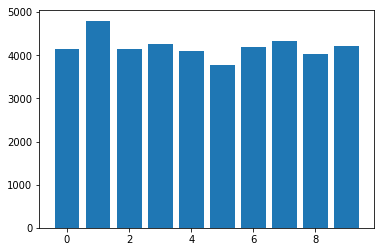

In [12]:
data_label = label_data.ix[:,'5']
class_label = data_label.value_counts(sort = False)
training_label = class_label.as_matrix()
plt.bar(np.arange(10), height = training_label)
plt.show()

As we can see, the distribution in tranining data is not skewed, every elements in the tranining data have the same frequencies

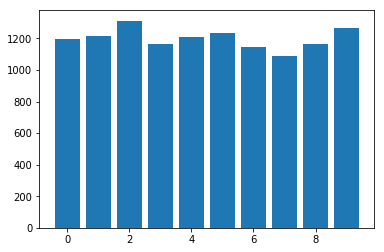

In [13]:
validate_label = label_validate.ix[:,'5']
class_validate_label = validate_label.value_counts(sort = False)
class_validate_label = class_validate_label.as_matrix()
plt.bar(np.arange(10), height = class_validate_label)
plt.show()

In cross validate data set, the distribution is not change

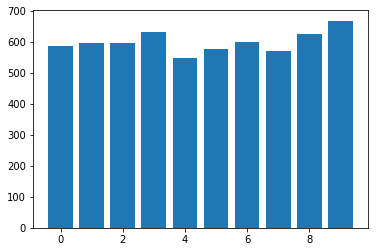

In [14]:
test_label = label_test.ix[:,'5']
class_test_label = test_label.value_counts(sort = False)
class_test_label = class_test_label.as_matrix()
plt.bar(np.arange(10), height = class_test_label)
plt.show()


Look at 3 bar graphs, we can see in every phase, each phase has same distribution, this means Covariate shift equals to 0

In [15]:
data = train_data[0:42000,:]
validate = train_data[42001:54000,:]
testdata = train_data[54001:59998,:]

label_data = label[0:42000]
label_validate = label[42001:54000]
label_test = label[54001:59998]


I split the data to the ratio 70:20:10 corespoding to training data: cross validate data: test data

In [16]:
def one_hot_encoding(x):
    temp = np.zeros((len(x), 10))             #10 classes
    temp[np.arange(len(x)), x] = 1
    return temp

# Data Dimensions
I list the data dimension below

In [17]:
image_size = 28

image_size_flat = image_size*image_size

image_shape = (image_size,image_size)

num_channels = 1

num_classes = 10

# Function to plot image

In [18]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 25
    
    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(image_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

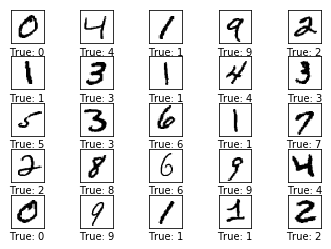

In [19]:
# Get the first images from the test-set.
images = data[0:25,:]

# Get the true classes for those images.
cls_true = label_data[0:25]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Functions to initialize weights and biases
I use truncated_normal with mean 0 and stddv = 1 because i want to cut off tail of the normal distribution in order to avoid saturation of neurons

In [20]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape))

def new_biases(length):
    return tf.Variable(tf.constant(0.0, shape=[length]))

# Function to create Convolutional Layers

In [21]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in previous layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input, ################################################################# conv2d
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

# Function for flattening a layer
Convolutional Layer output a rank 4 tensor, we need to reshape it to rank 4 tensor to feed to feed forward layers
in rank 4 tensor, 3 dimensions are for shape of the feature maps, the last dimension is for number of image fed to the Convolutional Layer

In feed forward layers, 1 dimension is for input and 1 dimension is for number of input

In [22]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

# Fully Connected Layers

In [23]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [24]:
x = tf.placeholder(tf.float32, shape=[None, image_size_flat], name='x')
x_image = tf.reshape(x, [-1, image_size, image_size, num_channels])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.argmax(y_true, dimension=1)

# Convolutional Layer 1

In [25]:
filter_size1 = 5
num_filters1 = 6 

In [26]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                           num_input_channels=num_channels,
                                           filter_size=filter_size1,
                                           num_filters=num_filters1,
                                           use_pooling=True)

In [27]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 6) dtype=float32>

# Convolutional Layer 2

In [28]:
filter_size2 = 5        
num_filters2 = 36  

In [29]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

In [30]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

# Flatten Layer

In [31]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [32]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

# Fully Connected Layers

In [33]:
fc_size = 128

In [34]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [35]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

# Fully Connected Layers 2

In [36]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [37]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

# Predict class

In [38]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Model Architecture

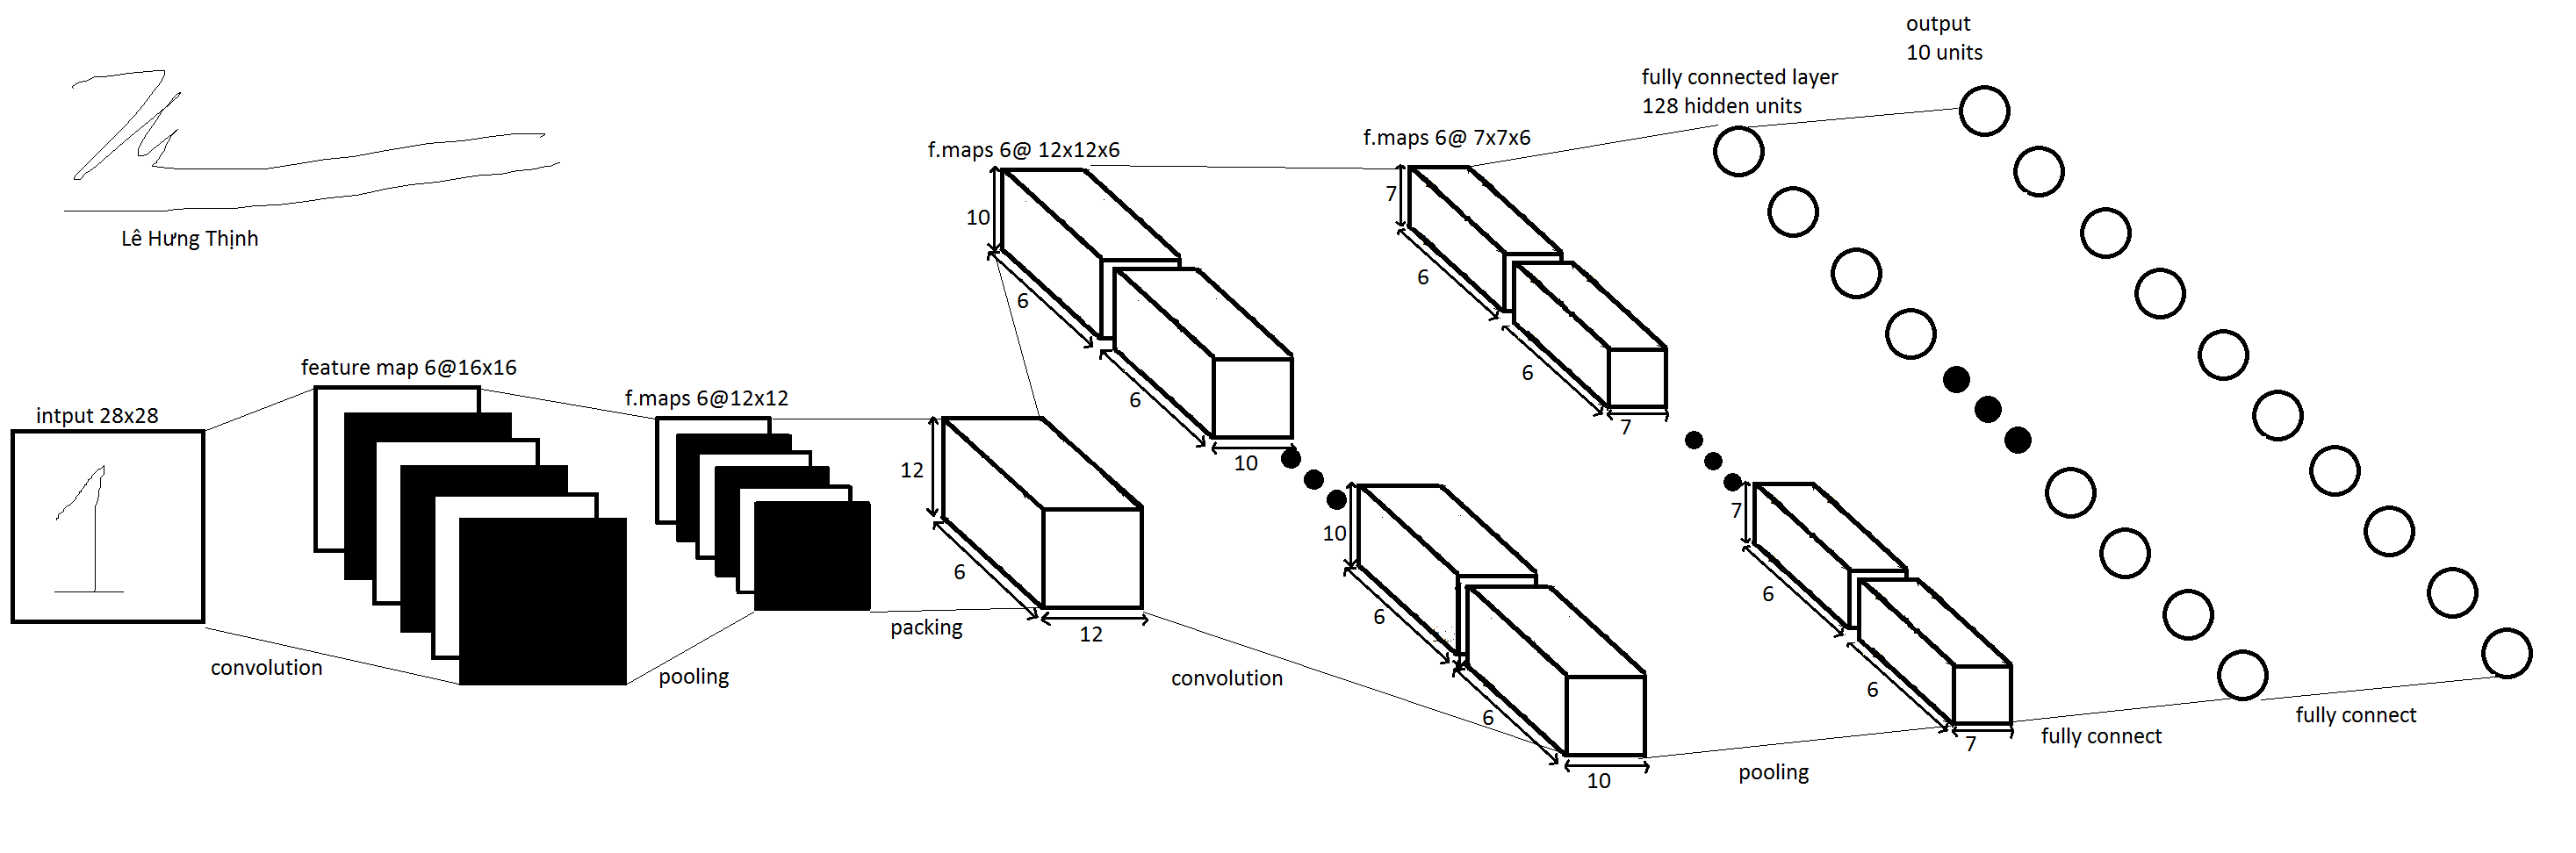

In [39]:
from IPython.display import Image
Image('CNNARCHITECTURE.png')

# Cost function

In [40]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [41]:
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Caculating the accuracy

In [42]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# The above is for building a graph, now we are feed data to train the model

In [43]:
session = tf.Session()
session.run(tf.global_variables_initializer())

# Feed data into model

In [44]:
batch_size = 100
steps = len(data)/batch_size
steps = int(steps)
err_test = list()
err_validate = list()
acc_test = list()
acc_validate = list()
def optimize(num_iterations):
    for i in range(num_iterations):
        k = 0
        for j in range(steps):
            x_batch = data[k:k+ batch_size,:] 
            y_true_batch = label_data[k:k+ batch_size]

            y_true_batch = one_hot_encoding(y_true_batch)
           
            k = k + batch_size
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}
            session.run(optimizer, feed_dict=feed_dict_train)
            
        err_test.append(print_loss(feed_dict_test))
        err_validate.append(print_loss(feed_dict_validate))
        print("time: {0}, loss on validate set: {1}, loss on data: {2}".format(i, print_accuracy(feed_dict_validate), print_accuracy(feed_dict_test)))
        acc_validate.append(print_accuracy(feed_dict_validate))
        acc_test.append(print_accuracy(feed_dict_test))

In [45]:
feed_label_validate = one_hot_encoding(label_validate)
validate_class = np.array([label.argmax() for label in feed_label_validate])
feed_dict_validate = {x: validate,
                  y_true: feed_label_validate,
                  y_true_cls: validate_class}

In [46]:
feed_label_test = one_hot_encoding(label_data)
test_class = np.array([label.argmax() for label in feed_label_test])
feed_dict_test = {x: data,
                  y_true: feed_label_test,
                  y_true_cls: test_class}

In [47]:
def print_accuracy(feed_dict_):
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict_)
    
    # Print the accuracy.
    #print("Accuracy on test-set: {0:.1%}".format(acc))
    return acc

In [48]:
def print_loss(feed_dict_):
    # Use TensorFlow to compute the accuracy.
    acc = session.run(cost, feed_dict_)
    
    # Print the accuracy.
    #print("Accuracy on test-set: {0:.1%}".format(acc))
    return acc

In [49]:
err_validate.append(print_loss(feed_dict_validate))
err_test.append(print_loss(feed_dict_test))

In [50]:
optimize(num_iterations=100)

time: 0, loss on validate set: 0.836069643497467, loss on data: 0.8491666913032532
time: 1, loss on validate set: 0.8851571083068848, loss on data: 0.8985475897789001
time: 2, loss on validate set: 0.9074089527130127, loss on data: 0.9208095073699951
time: 3, loss on validate set: 0.9187432527542114, loss on data: 0.9351666569709778
time: 4, loss on validate set: 0.9274939298629761, loss on data: 0.9456666707992554
time: 5, loss on validate set: 0.9319109916687012, loss on data: 0.951714277267456
time: 6, loss on validate set: 0.9386615753173828, loss on data: 0.95804762840271
time: 7, loss on validate set: 0.9416618347167969, loss on data: 0.9652618765830994
time: 8, loss on validate set: 0.9445787072181702, loss on data: 0.9680714011192322
time: 9, loss on validate set: 0.9484123587608337, loss on data: 0.9730714559555054
time: 10, loss on validate set: 0.9475789666175842, loss on data: 0.972428560256958
time: 11, loss on validate set: 0.9512459635734558, loss on data: 0.978880941867

# Testing time

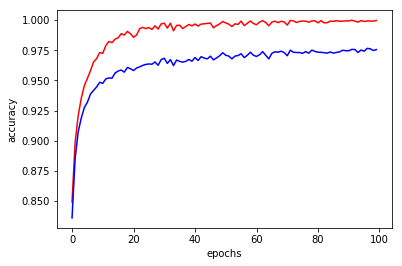

In [51]:
fig = plt.figure()
plt.plot(range(len(acc_test)),acc_test,'r')
plt.plot(range(len(acc_validate)),acc_validate,'b')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#plt.title('accuracy on validate data')
plt.show()
fig.savefig('Adam_fulldata_CNNcrossvalidatealpha00001.png')

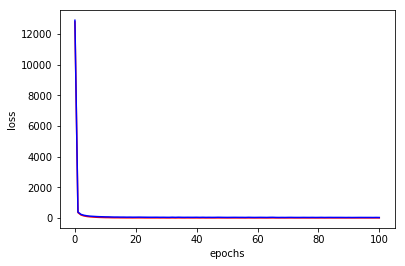

In [52]:
fig = plt.figure()
plt.plot(range(len(err_test)),err_test,'r')
plt.plot(range(len(err_validate)),err_validate,'b')
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.title('accuracy on validate data')
plt.show()
fig.savefig('AdamCNNlossalpha00001.png')

In [110]:
target = validate[0:1,:]
label_validate[0:1]

array([1], dtype=int64)

In [111]:
x_batch = target
feed_test = {x: x_batch}
session.run(y_pred_cls, feed_dict=feed_test)

array([1], dtype=int64)